In [10]:
import os
filenames = []
for root, dirs, files in os.walk("saved_plays", topdown=True):
    if root is not 'neither':
        for name in files:
            filenames.append(os.path.join(root, name))

In [11]:
import pandas as pd

filenames = [f for f in filenames if 'DS_Store' not in f]
df = pd.DataFrame({'filename': filenames})

In [12]:
df['type'] = df['filename'].str.split('/').apply(lambda x: x[2])
df['side'] = df['filename'].str.split('/').apply(lambda x: x[1])

In [13]:
df.head()

,filename,type,side
0,saved_plays/right/pass/Madden NFL 19_201903151...,pass,right
1,saved_plays/right/pass/Madden NFL 19_201904031...,pass,right
2,saved_plays/right/pass/Madden NFL 19_201905011...,pass,right
3,saved_plays/right/pass/Madden NFL 19_201903232...,pass,right
4,saved_plays/right/pass/Madden NFL 19_201904271...,pass,right


In [16]:
df['neither'] = df['filename'].apply(lambda x: 'neither' in x)*1
df = df[ df['neither'] == 0]
df.drop('neither', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df['type'].value_counts()

pass    382
run     161
fake     15
Name: type, dtype: int64

In [18]:
#df.to_csv('type_dataset.csv')

In [29]:
from torch.utils.data import Dataset
import cv2 as cv

# Make Dataset class
label_map = {'pass': 0, 'run': 1, 'fake': 2}

class PlayTypeDataset(Dataset):
    
    def __init__(self, csv_file, transform=None):
        '''
        '''
        self.dataframe = pd.read_csv(csv_file, index_col=0)
        self.transform = transform
        self.size = (300,100)
        
    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        '''
        '''
        img_name = self.dataframe.iloc[idx, 0]
        
        image = cv.imread(img_name)
        #image = cv.cvtColor(image, cv.COLOR_RGB2BGR)
        #
        image = cv.resize(image, self.size)

        label = self.dataframe.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)
        
        return (image, label_map[label])

In [30]:
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import numpy as np

validation_indices = []

def get_training_and_validation_loaders(dataset, batch_size = 16, validation_split = .2):
    
    shuffle_dataset = True
    random_seed = 8

    # Creating data indices for training and validation splits:
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))

    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)
    #
    validation_indices = val_indices
    
    return train_loader, validation_loader

In [31]:
from torchvision import transforms

trans = transforms.Compose([transforms.ToTensor(), 
                            transforms.Normalize((0.5,), (0.5,)),
                           ])

dset = PlayTypeDataset('type_dataset.csv', trans)

In [32]:
x, y = dset[0]
x.shape

torch.Size([3, 100, 300])

In [33]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 
train_loader, validation_loader = get_training_and_validation_loaders(dset, batch_size=15)

In [34]:
batch, labels = next(iter(train_loader))

In [75]:


conv1 = nn.Conv2d(3, 16, kernel_size=5)
x = F.relu(F.max_pool2d(conv1(batch), 2))
print(x.shape)
# torch.Size([15, 16, 48, 148])

conv2 = nn.Conv2d(16, 32, kernel_size=5)
x = F.relu(F.max_pool2d(conv2(x), 2))
print(x.shape)
# torch.Size([15, 32, 22, 72])

conv3 = nn.Conv2d(32, 64, kernel_size=5)
x = F.relu(F.max_pool2d(conv3(x), 2))
print(x.shape)
# torch.Size([15, 64, 9, 34])

x = x.view(15, -1)
# torch.Size([15, 19584])

fc1 = nn.Linear(19584, 100)
x = F.relu(fc1(x))
torch.Size([15, 100])


torch.Size([15, 16, 48, 148])
torch.Size([15, 32, 22, 72])
torch.Size([15, 64, 9, 34])
torch.Size([15, 100])


In [74]:
x.view(15, -1).shape

torch.Size([15, 19584])

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(19584, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 3)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape) # [N, 64, 72, 42]
        x = F.relu(F.max_pool2d(self.conv3(x), 2))
        #print(x.shape) # [N, 128, 34, 19]
        #x = F.relu(F.max_pool2d(x, 2))
        #print(x.shape) # [N, 128, 17, 9]
        x = x.view(-1, 19584)
        #print(x.shape) # 
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        #print(x.shape)
        return F.log_softmax(x, dim=1)

    def name(self):
        return "mutclipside_may19"

In [39]:
# HPs
lr = 0.01 # 0.001 too small

# Model
model = Net().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr = lr, momentum=0.9)

loss_list = []
acc_list = []
train_losses = []
train_accuracies = []
train_losses2 = []
#
num_epochs = 40

for epoch in range(num_epochs):
        
    # Train:   
    total = 0
    correct = 0
    trainlosses = []
    
    for batch_index, (images, labels) in enumerate(train_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        trainlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
    train_losses.append( np.mean(trainlosses) )
    train_accuracies.append( correct/total )
    train_losses2.extend(trainlosses)
                        
    with torch.no_grad():
        
        losses = []
        total = 0
        correct = 0
    
        for images, labels in validation_loader:
            # 
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images.float())
            
            loss = criterion(outputs, labels)
        
            # Compute accuracy
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item() #.mean()
            total += len(labels)
            
            losses.append(loss.item())
    
        acc = np.round(correct/total, 3)
        loss = np.mean(losses)
        
        acc_list.append(acc)
        loss_list.append(loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {np.mean(losses):.4}, Acc: {correct/total:.2}')

Epoch [1/40], Loss: 0.7719, Acc: 0.67
Epoch [2/40], Loss: 0.7051, Acc: 0.67
Epoch [3/40], Loss: 0.701, Acc: 0.67
Epoch [4/40], Loss: 0.7214, Acc: 0.67
Epoch [5/40], Loss: 0.7067, Acc: 0.67
Epoch [6/40], Loss: 0.6925, Acc: 0.68
Epoch [7/40], Loss: 0.6794, Acc: 0.67
Epoch [8/40], Loss: 0.6582, Acc: 0.67
Epoch [9/40], Loss: 0.6533, Acc: 0.63
Epoch [10/40], Loss: 0.665, Acc: 0.65
Epoch [11/40], Loss: 0.6748, Acc: 0.68
Epoch [12/40], Loss: 0.7935, Acc: 0.69
Epoch [13/40], Loss: 0.5899, Acc: 0.67


KeyboardInterrupt: 

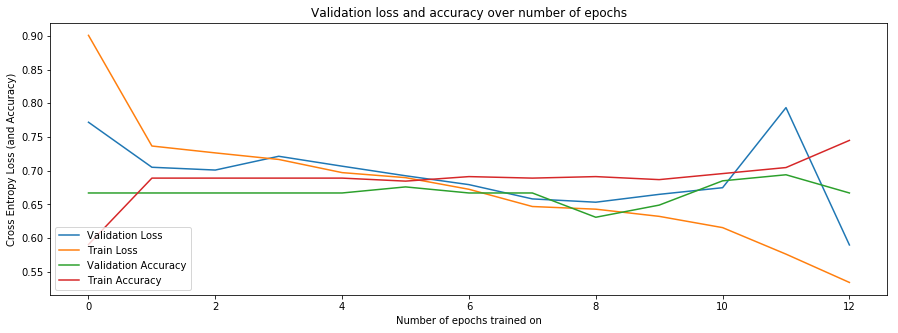

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplots(figsize=(15,5))
plt.plot(loss_list); # blue
plt.plot(train_losses);
plt.plot(acc_list); # orange
plt.plot(train_accuracies);
plt.title('Validation loss and accuracy over number of epochs');
plt.xlabel('Number of epochs trained on');
plt.ylabel('Cross Entropy Loss (and Accuracy)');
plt.legend(['Validation Loss', 'Train Loss', 'Validation Accuracy', 'Train Accuracy'], loc='lower left');

In [42]:
# Test
model.eval()

total = 0
correct = 0
testlosses = []
correct_labels = []
predictions = []

with torch.no_grad():
    
    for batch_index, (images, labels) in enumerate(validation_loader):
        # Send to GPU (device)
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images.float())
        
        # Loss
        loss = criterion(outputs, labels)
        
        testlosses.append(loss.item())
        
        # Compute accuracy
        _, argmax = torch.max(outputs, 1)
        correct += (labels == argmax).sum().item() #.mean()
        total += len(labels)
        
        correct_labels.extend(labels)
        predictions.extend(argmax)
        

test_loss = np.mean(testlosses)
accuracy = np.round(correct/total, 2)
print(f'Loss: {test_loss:.4}, Acc: {accuracy:.2}')

Loss: 0.5014, Acc: 0.81


In [43]:
from sklearn.metrics import confusion_matrix

y_true = [label.item() for label in correct_labels]
y_pred = [label.item() for label in predictions]

cm = confusion_matrix(y_true, y_pred)

cm

array([[72,  2,  0],
       [19, 17,  0],
       [ 0,  0,  1]])

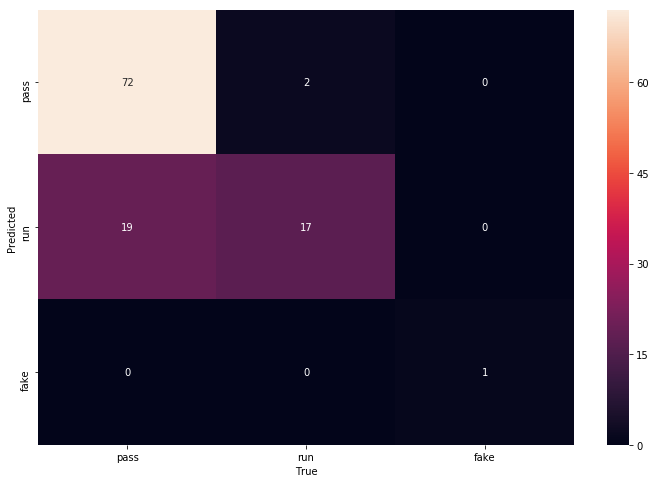

In [44]:
import seaborn as sns

plt.subplots(figsize=(12,8));
sns.heatmap(cm, annot=True, fmt='g', yticklabels=label_map.keys(),
            xticklabels=label_map.keys());

plt.xlabel('True');
plt.ylabel('Predicted');